In [8]:
using PyPlot, ForwardDiff, TaylorSeries, LinearAlgebra, Roots
function rescale!(x::Taylor1,lambda)
    mult = one(lambda);
    for i in 2:length(x.coeffs)
        mult /= lambda
        x.coeffs[i] *= mult
    end
    x
end
ForwardDiff.can_dual(::Type{Taylor1{Float64}}) = true
Base.isinteger(::Taylor1{Float64}) = false

In [9]:
# function sol(x,y) 
# #     @assert 0<=x<1
#     xn, yn = 2x+0.25sinpi(2x)/2pi+0.02cospi(2y), 0.4y+0.4sinpi(2x)
#     isodd(floor(Int,xn)) && (yn *= -1)
#     mod(xn,1),yn
# end
# sol(x,y) = mod.((2x+y,x+y-0.05sinpi(2x+2y)),1
function sol(x,y)
    xn,yn = mod.((2x+y,x+y),1)
    contractionamt = -0.5+mod((1+sqrt(5))\2xn-yn,1)
    a = 1; b = 0.5; c = 4/a
    yn += exp(c-1/(a*xn*(1-xn)))*contractionamt*b
    xn,mod(yn,1)
end
sol(x) = [sol(x...)...]

function Jsol(x,y)
    Jcat = [2 1; 1 1]
    xn,yn = mod.((2x+y,x+y),1)
    contractionamt = -0.5+mod((1+sqrt(5))\2xn-yn,1); 
    d_contractionamt = [(1+sqrt(5))\2 -1]
    a = 1; b = 0.5; c = 4/a
    expamt = exp(-1/(a*xn*(1-xn))); d_expamt = [expamt*(1-2xn)/(a*((1-xn)*xn)^2) 0]
    Jcat + [0 0; (d_contractionamt*expamt + d_expamt*contractionamt)]*b*Jcat
end


Jsol (generic function with 1 method)

In [17]:
t = Taylor1(Float64,2)
(xsol,ysol) = 0.2rand(2) .+ t
# vusol = randn(2)+dualnum*randn(2)
for i = 1:10000
    (xsol,ysol) = sol(xsol,ysol); lusol = hypot(xsol[1],ysol[1])
    rescale!(xsol,lusol); rescale!(ysol,lusol)
#     println(xsol)
#     vusol = Jsol([xsol,ysol])*vusol; vusol /= norm(realpart.(vusol)) # to make make sense....
#     println(vusol)
end
N = 1_000_000
solh = Array{typeof(xsol)}(undef,N,2)
# vusolh = Array{Dual{Float64}}(undef,N,2)
lusolh = Array{Float64}(undef,N)
for i = 1:N
    (xsol,ysol) = sol(xsol,ysol); lusol = hypot(xsol[1],ysol[1])
    rescale!(xsol,lusol); rescale!(ysol,lusol)
    solh[i,1] = xsol; solh[i,2] = ysol
    lusolh[i] = lusol
end
dxdtnorm = sqrt.(differentiate.(solh[:,1]).^2 + differentiate.(solh[:,2]).^2)
rhograds = getindex.(1 ./dxdtnorm,1);

In [18]:
lsol = rand(2) .+ differentiate(t^2/2)
lsolh = Array{Taylor1{Float64}}(undef,N,2)
lsolh[N,:] = lsol
for i = N-1:-1:1
    lsol = Jsol(solh[i,1],solh[i,2])'*lsol; 
    lsol /= dot(differentiate.(solh[i,:])/dxdtnorm[i],lsol)
    lsolh[i,:] = lsol
    end
lnorms = vec(mapslices(x->norm(getcoeff.(x,0)),lsolh,dims=2))
dldt = getcoeff.(lsolh,1);

In [19]:
krhopart = rhograds.*getcoeff.(lsolh,0); krhonorms = abs.(rhograds) .* lnorms
kXnorms = lnorms;
klpart = dldt ./ getcoeff.(dxdtnorm,0); klnorms = vec(mapslices(norm,klpart,dims=2));

In [20]:
Xv = [sinpi.(2getcoeff.(solh[:,1],0)) zeros(N)]
DXvxx = 2pi*cospi.(2getcoeff.(solh[:,1],0))
lrtdensity = vec(sum((krhopart + klpart).*Xv,dims=2) + 
    getcoeff.(lsolh[:,1],0).*(DXvxx.*getcoeff.(solh[:,1],1)./getcoeff.(dxdtnorm,0)));

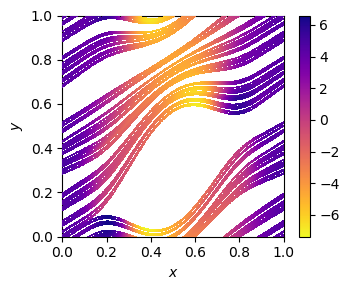

In [22]:
# imshow(log10.(1 .-dotprodmat'),extent=(extrema(exes)...,reverse(extrema(wyes))...)); #colorbar()
figure(figsize=(3.8,3))
scatter(map.(solh[:,1],0),map.(solh[:,2],0),c=lrtdensity,marker=",",s=0.25,linewidth=0,
    #norm=matplotlib.colors.LogNorm(vmin=1, vmax=1e6),
    cmap="plasma_r",zorder=3)
gca().set_aspect("equal")
xlim(0,1);ylim(0,1); 
xlabel("\$x\$");ylabel("\$y\$")
colorbar()
tight_layout()
savefig("../figures/Spaghetti-hyperbolic.png",dpi=500)